# Imports

In [1]:
path = '/path/to/files/'

import numpy as np
import h5py
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import copy

Mounted at /content/drive


# Data Loading

In [2]:
# means and standard deviations of the training background data (calculated previously and hard coded here)

mean = torch.tensor([ 3.5323e+01,  0.0000e+00, -2.4029e-04,  1.9210e+01, -1.0124e-04,
         2.5973e-04,  9.1067e-01, -6.5868e-05, -7.1560e-05,  6.6114e-03,
        -3.3393e-06,  2.4320e-05,  2.2921e-04, -6.8692e-06, -1.5058e-06,
         1.6659e+01, -2.8810e-04,  2.8312e-04,  7.6219e-01, -4.0819e-06,
        -9.9671e-06,  4.8101e-03,  2.1597e-06, -3.3575e-06,  1.0791e-04,
         2.8055e-06, -3.3978e-06,  3.2973e+01, -1.0638e-03, -6.3158e-04,
         1.2439e+01, -7.2716e-04, -2.9234e-04,  4.0353e+00, -6.2874e-04,
         3.4069e-04,  1.3062e+00, -1.3706e-04,  2.4723e-04,  4.1298e-01,
        -1.8951e-05, -7.5695e-05,  1.2892e-01, -1.1739e-04, -7.2818e-05,
         3.9955e-02,  4.3719e-05, -3.3163e-05,  1.1803e-02,  2.5562e-05,
        -1.9536e-05,  3.3738e-03, -4.4075e-06, -1.8542e-05,  1.0058e-03,
         5.1200e-06,  1.0992e-06])

st_dev = torch.tensor([2.0682e+01, 1.0000e+00, 1.8137e+00, 2.0383e+01, 1.1525e+00, 1.3394e+00,
        5.3141e+00, 2.9130e-01, 3.6610e-01, 2.6897e-01, 3.9485e-02, 5.2045e-02,
        4.3149e-02, 8.4674e-03, 1.0258e-02, 1.9919e+01, 8.1926e-01, 1.2531e+00,
        4.9369e+00, 1.9996e-01, 3.2483e-01, 2.3870e-01, 2.5161e-02, 4.2108e-02,
        3.3005e-02, 3.7164e-03, 6.4660e-03, 4.0788e+01, 1.3722e+00, 1.4294e+00,
        2.4208e+01, 1.0434e+00, 1.0328e+00, 1.1905e+01, 7.0497e-01, 6.7883e-01,
        6.2800e+00, 4.3222e-01, 4.1477e-01, 3.3430e+00, 2.5179e-01, 2.4315e-01,
        1.7942e+00, 1.4354e-01, 1.3963e-01, 9.6469e-01, 7.9824e-02, 7.9750e-02,
        5.1084e-01, 4.4059e-02, 4.4119e-02, 2.6544e-01, 2.3168e-02, 2.3841e-02,
        1.4149e-01, 1.2838e-02, 1.3387e-02])

class SignalDataset(Dataset):
    def __init__(self, signal_file):
        with h5py.File(signal_file, 'r') as file:
            self.data = torch.tensor(np.array(file['data'])).type(torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        data_sample = self.data[index]
        normalized_sample = (data_sample - mean) / st_dev
        loss = torch.mean(torch.pow(normalized_sample, 2))
        return normalized_sample, loss

class BkgDataset(Dataset):
    def __init__(self, bkg_dataset):
        self.data = bkg_dataset

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        data_sample = self.data[index]
        normalized_sample = (data_sample - mean) / st_dev
        loss = torch.mean(torch.pow(normalized_sample, 2))
        return normalized_sample, loss

def get_dataloaders(path, BATCH_SIZE = 1024):
    bkg_file = path + "all_background_processed.h5"
    signal_files = [
        path + 'all_leptoquark_processed.h5',
        path + 'all_Ato4l_processed.h5',
        path + 'all_hChToTauNu_processed.h5',
        path + 'all_hToTauTau_processed.h5',
    ]
    signal_labels = ['leptoquark','Ato4l','hChToTauNu', 'hToTauTau']


    list_of_signal_dataloaders = [DataLoader(SignalDataset(signal_file),
                                             batch_size= BATCH_SIZE,
                                             shuffle=True)
                                        for signal_file in signal_files]

    # Initialize background data
    with h5py.File(bkg_file, 'r') as file:
            bkg_data = torch.tensor(np.array(file['data'])).type(torch.float32)

    #Split Data
    total_length = len(bkg_data)
    train_boundary = int(0.4 * total_length)
    val_boundary = int(0.5 * total_length)

    bkg_train = bkg_data[:train_boundary]
    bkg_val = bkg_data[train_boundary:val_boundary]
    bkg_test = bkg_data[val_boundary:]
    del(bkg_data)

    bkg_trainloader = DataLoader(BkgDataset(bkg_train), batch_size=BATCH_SIZE, shuffle=True)
    bkg_valloader = DataLoader(BkgDataset(bkg_val), batch_size=BATCH_SIZE, shuffle=False)
    bkg_testloader = DataLoader(BkgDataset(bkg_test), batch_size=BATCH_SIZE, shuffle=False)

    return list_of_signal_dataloaders, bkg_trainloader, bkg_valloader, bkg_testloader, signal_labels

In [3]:
path = '/content/drive/MyDrive/AE/Sparse_AE/data/'
BATCH_SIZE = 5000
list_of_signal_dataloaders, bkg_trainloader, bkg_valloader, bkg_testloader, signal_labels = get_dataloaders(path, BATCH_SIZE)

# Check Means and Standard Deviations

In [4]:
def compute_mean_std_for_loader(loader):
    data_list = []

    for data, loss in loader:
        data_list.append(data)

    # Stack the data
    all_data = torch.cat(data_list, dim=0)

    # Compute mean and std
    mean = torch.mean(all_data, dim=0)
    st_dev = torch.std(all_data, dim=0)

    return mean, st_dev

In [5]:
means, st_devs = compute_mean_std_for_loader(bkg_trainloader)
print(st_devs, means)

tensor([1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000]) tensor([-7.1364e-06,  0.0000e+00,  1.4370e-08,  2.1894e-05, -1.4333e-08,
         7.0413e-09, -7.8112e-07, -2.1070e-08,  9.3752e-09,  8.2261e-08,
        -8.7385e-09,  7.2705e-09, -5.0313e-08,  5.9704e-09,  1.9314e-10,
        -9.1691e-06, -1.3117e-08, -6.6641e-09,  1.0317e-07, -1.7114e-08,
        -2.9101e-08,  1.3064e-07, -6.6358e-10, -3.9701e-09, -8.5795e-08,
         7.0767e-09, -2.2267e-09, -9.3880e-06,  2.1502e-08,  4.8492e-09,
         1.5899e-05,  3.6670e-08,  8.1444e-09, -3

# Methods

In [6]:
# returns tpr value for specific threshold
def get_tpr(threshold, signal_losses):
    tpr = torch.sum(signal_losses > threshold).float() / len(signal_losses)
    return tpr

# retruns threshold given an fpr
def get_threshold(fpr, background_losses):
    background_losses = background_losses.sort()[0]
    num_false_pos = int(len(background_losses) * fpr)
    threshold = background_losses[-num_false_pos]
    return threshold

# exponential linespace to cover large threshold
def powspace(start, stop, power, num):
    start = np.power(start, 1/float(power))
    stop = np.power(stop, 1/float(power))
    return np.power( np.linspace(start, stop, num=num), power)

def print_tprs(background_losses, list_of_signal_losses, signal_labels, fpr = 1e-5):
    threshold = get_threshold(fpr, background_losses)
    for idx, signal_losses in enumerate(list_of_signal_losses):
      tpr = get_tpr(threshold, signal_losses)
      print(f"{signal_labels[idx]} {tpr.item():.7f}")

In [18]:
def plot_auc(background_losses, list_of_signal_losses, list_of_signal_labels, num_fprs=10):
    fprs = powspace(5e-6, 1, 5, num_fprs)

    for signal_losses, signal_label in zip(list_of_signal_losses, list_of_signal_labels):
        tprs = torch.zeros(num_fprs)
        for fpr_idx, fpr in enumerate(fprs):
            threshold = get_threshold(fpr, background_losses)
            tpr = get_tpr(threshold, signal_losses)
            tprs[fpr_idx] = tpr

        # Plot curve for the current signal dataset
        plt.plot(fprs, tprs.numpy(), label=f'{signal_label}, auc: {round(auc(fprs, tprs.numpy()), 2)}')

    plt.semilogx()
    plt.semilogy()
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.legend(loc='center right')
    plt.grid(True)
    plt.tight_layout()
    plt.plot(np.linspace(0, 1), np.linspace(0, 1), '--', color='0.75')
    plt.axvline(0.00001, color='red', linestyle='dashed', linewidth=1) # threshold value
    plt.title("ROC AE")

    plt.show()

def plot_histogram(background_losses, list_of_signal_losses, list_of_signal_labels, bin_size):
    # calculate the total number of events
    total_events = background_losses.size(0) + sum([loss.size(0) for loss in list_of_signal_losses])

    plt.figure(figsize=(10,8))

    # weights for the background
    background_weights = np.ones_like(background_losses.cpu().numpy()) * background_losses.size(0) / total_events

    plt.hist(background_losses.cpu().numpy(), bins=bin_size, density=True, histtype='step', fill=False, linewidth=1.5, label='background', weights=background_weights)

    # iterate through each signal and plot
    for signal_losses, label in zip(list_of_signal_losses, list_of_signal_labels):
        signal_weights = np.ones_like(signal_losses.cpu().numpy()) * signal_losses.size(0) / total_events
        plt.hist(signal_losses.cpu().numpy(), bins=bin_size, density=True, histtype='step', fill=False, linewidth=1.5, label=label, weights=signal_weights)

    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel("Loss")
    plt.ylabel("Probability (a.u.)")
    plt.title('MSE loss')
    plt.legend()
    plt.show()

# Calculate TPRs

In [8]:
bkg_losses = []
for data, loss in bkg_testloader:
    bkg_losses.append(loss)
bkg_losses = torch.cat(bkg_losses, 0)

list_of_signal_losses = []
for signal_dataloader in list_of_signal_dataloaders:
  signal_losses = []
  for data, loss in signal_dataloader:
      signal_losses.append(loss)
  signal_losses = torch.cat(signal_losses, 0)
  list_of_signal_losses.append(signal_losses)

In [9]:
print_tprs(bkg_losses, list_of_signal_losses, signal_labels)

leptoquark 0.0004405
Ato4l 0.0372528
hChToTauNu 0.0004051
hToTauTau 0.0004976


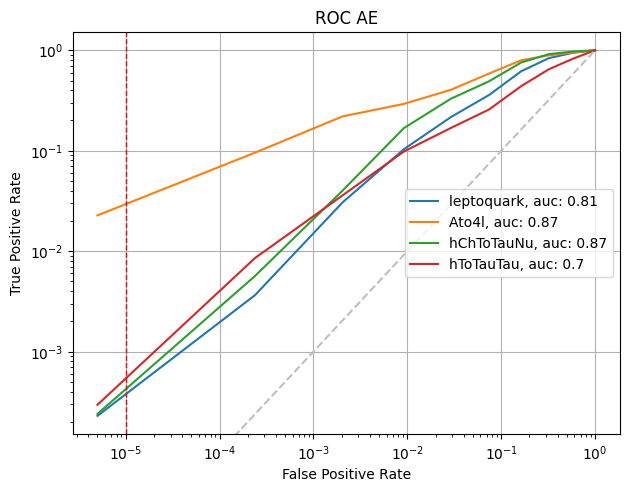

In [10]:
plot_auc(bkg_losses, list_of_signal_losses, signal_labels)

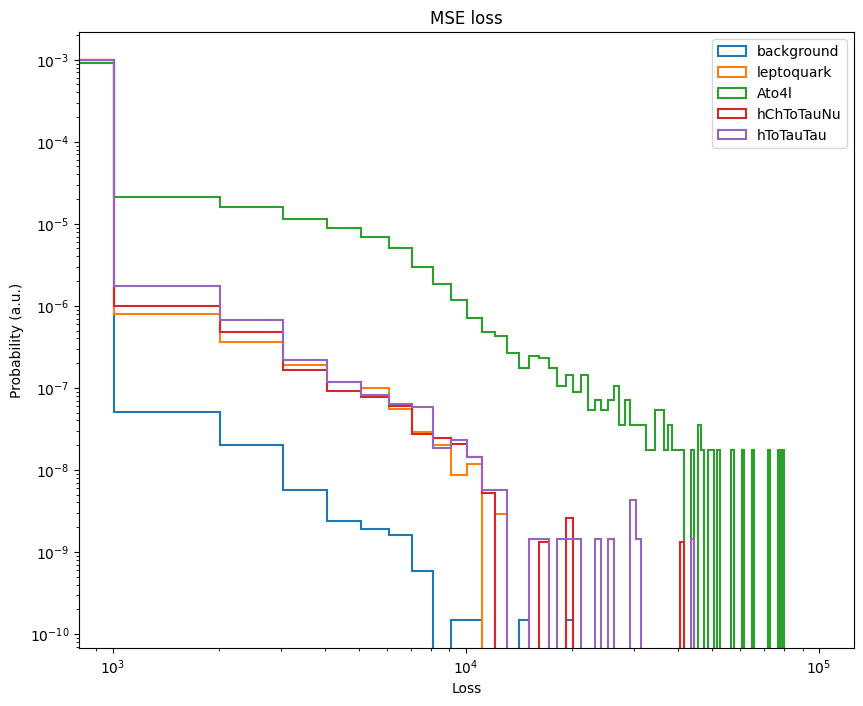

In [19]:
plot_histogram(bkg_losses, list_of_signal_losses, signal_labels, bin_size = np.linspace(0, 10e4, 100))